In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import chi2 
from scipy.stats import f as Fisher 
from scipy.stats import t as Student


In [23]:
#получение данных из варианта
data = pd.read_excel(os.path.join('РГЗ_СМАД_2021_данные.xlsx'),
                   sheet_name='V.2',
                   engine='openpyxl').drop(['Unnamed: 5', 'Unnamed: 6'], axis=1)
m = len(data.columns) - 2
n = len(data)
X = np.array(data[['Х1', 'Х2', 'Х3', 'Х4']])
y = np.array(data[['y']])

In [24]:
#-----------------------------------------------------
#проверка данных на мультиколлинеарность
print('Проверка данных на мультиколлинеарность')
print('Меры измерения эффекта мультиколлинеарности')

# определитель информационной матрицы
det = np.linalg.det(X.T@X)
print("Определитель информационной матрицы: " + str(round(det,3)))

#минимальное собственное число
lambdas = np.linalg.eigvals(X.T@X)
lambda_min = min(lambdas)
print("\nМинимальное собственное число матрицы: " + str(round(lambda_min,3)))

#мера обусловленности матрицы
lambda_max = max(lambdas)
print("\nМера обусловленности матрицы: " + str(round(lambda_max/lambda_min,3)))

#максимальная парная сопряженность
R = np.eye(m)
Xt = [0]*m
for i in range(m):
    for j in range(n):
        Xt[i] += X[j][i]**2 
for i in range(m-1):
    for j in range(i+1, m):
        for k in range(n):
            R[i,j] += X[k][i] * X[k][j] / np.sqrt(Xt[i]*Xt[j])
            R[j,i] = R[i,j]
print('\nМатрица сопряженности:\n', np.round(R, 2))

r_max = 0;
for i in range(m-1):
    for j in range(i+1, m):
        if R[i,j]>r_max:
            r_max = R[i,j]
print("Показатель парной коллинеарности max|R|: " + str(np.round(r_max,2)))     

#максимальная сопряженность
Rt = [] 
for i in range(len(R)): 
    Rt.append(np.sqrt(1.0 - 1.0 / np.linalg.inv(R)[i][i])) 
print('\nRt:', (np.round(Rt, 5)))
R_max = np.max(Rt) 
print("Максимальная сопряженность: " + str(np.round(R_max, 5)))

#-----------------------------------------------------
#проверка данных на гетероскедастичность
print('\nПроверка данных на гетероскедастичность')
print('Тест Бреуша-Пагана: ')
u = X
pk = ((np.linalg.inv(X.T@X))@X.T)@(y)

#остатки
et = y - pk.T@u.T

#оценка дисперсии
dk = np.sum(et ** 2) / len(et)

#отклик
c = [et[i] ** 2 / dk for i in range(len(et))]
c = np.array(c)

Проверка данных на мультиколлинеарность
Меры измерения эффекта мультиколлинеарности
Определитель информационной матрицы: 5638974.469

Минимальное собственное число матрицы: 42.507

Мера обусловленности матрицы: 1.27

Матрица сопряженности:
 [[ 1.   -0.1  -0.03  0.  ]
 [-0.1   1.    0.    0.  ]
 [-0.03  0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
Показатель парной коллинеарности max|R|: 0

Rt: [0.10039 0.09529 0.03189 0.     ]
Максимальная сопряженность: 0.10039

Проверка данных на гетероскедастичность
Тест Бреуша-Пагана: 


In [25]:

def z():
    z = np.zeros((n, 2))
    i = 0
    for x1, x2, x3, x4 in zip(X[:,0], X[:,1], X[:,2], X[:,3]):
        z[i][0] = 1
        z[i][1] = np.exp(0.25 * x1**2 + 0.25 * x2**2 + 0.25 * x3**2 + 0.25 * x4**2)
        i = i + 1
    return np.array(z)
alpha = [1,0]

#оценка параметров альфа
Z = z()
alpha = ((np.linalg.inv(Z.T@Z))@Z.T)@(c)
#print(alpha)
C_ = (alpha.T@Z.T).T

#ESS
ESS = np.sum((C_ - c.mean()) ** 2)
print('ESS =', round(ESS, 3))
#квантиль распределения хи-квадрат
chi2 = chi2.ppf(0.95, 1)
if ESS / 2 > chi2:
    print(round(ESS / 2, 3), '>', chi2, 'Гипотеза о гомоскедастичности возмущений отвергается')
else:
    print(round(ESS / 2, 3), '<', chi2, 'Гипотеза о гомоскедастичности возмущений не отвергается')   
    
    
#-----------------------------------------------------
#ОМНК
def OMNK(X=X, p=0, y=y):
    n = len(X)
    V = np.zeros((n,n))
    i = 0
    for i in range(n-1):
        V[i][i+1] = -p
        V[i][i] = 1+p**2
        V[i+1][i] = -p
        i = i + 1
    V[0][0] = 1
    V[n-1][n-1] = 1

    pk= X.T@V
    pk= np.linalg.inv((X.T@V)@X)
    pk= ((pk@X.T)@V)@y
    return pk

#проверка на автокорреляцию
print('\nПроверка данных на автокорреляцию')
et = y - (pk.T@X.T).T
dw = np.array([(et[t] - et[t-1])**2 for t in range(n)]).sum() / (et**2).sum()
if dw > 0 and dw < 0.5:
    print('DW =', dw, ' - положительная автокорреляция')
else:
    if dw > 1.5 and dw < 2.5:
        print('DW =', dw, ' - отсутствие автокорреляции')
    else:
        if dw > 3.5 and dw < 4:
            print('DW =', dw, ' - отрицательная автокорреляция')
p = dw


ESS = 0.196
0.098 < 3.841458820694124 Гипотеза о гомоскедастичности возмущений не отвергается

Проверка данных на автокорреляцию



Оценка параметров лучшей модели процедурой Кохрейна-Оркатта:
[[0.59974362]]
[[0.61131589]]
[[0.61210249]]
p = [[0.61210249]]
pk = 
[[-0.12171334 -0.40557756  0.68998249  0.22324214  0.0107815 ]]

Оценка параметров полной модели процедурой Кохрейна-Оркатта:
[[-0.27306506]]
[[-0.27847667]]
[[-0.27853631]]
p = [[-0.27853631]]
pk1 = 
[[ 0.99605317 -0.0073067   1.00606616 -0.97549273  0.05505532 -2.00607868
  -0.01041881 -0.00398903 -0.16193413  0.01292635  0.0064719  -0.09977414
  -0.0143111  -0.00240105 -0.01043594]]
Гипотеза об адекватности модели по последним 6 наблюдениям:
F = 0.06369868251020915 => модель адекватна


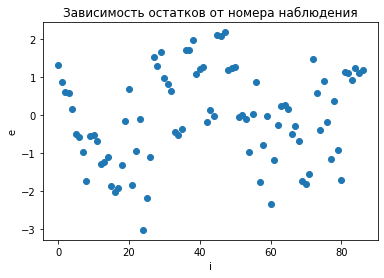

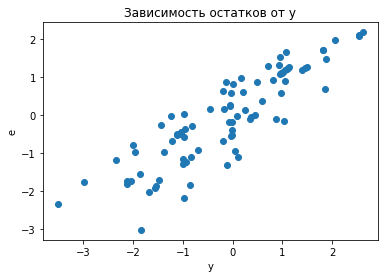

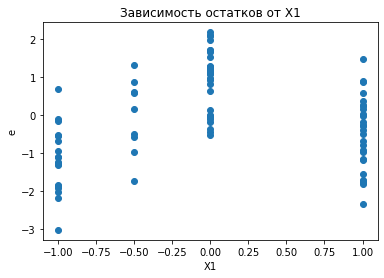

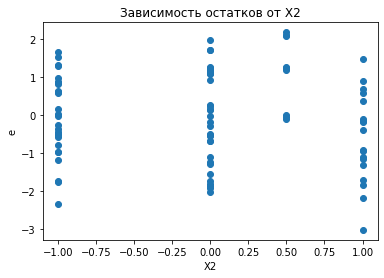

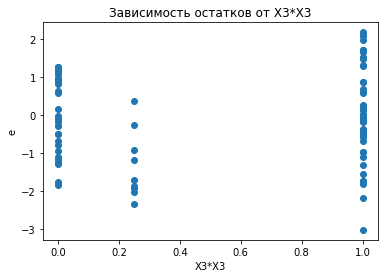

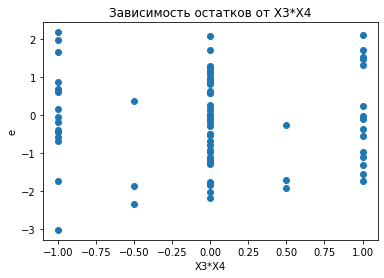

Доверительный интервал для максимального математического ожидания отклика:
[0.2802085235581441;2.1355321721813834]
y_max = 1.2078703478697637


Text(0.5, 1.0, 'X4 * X4')

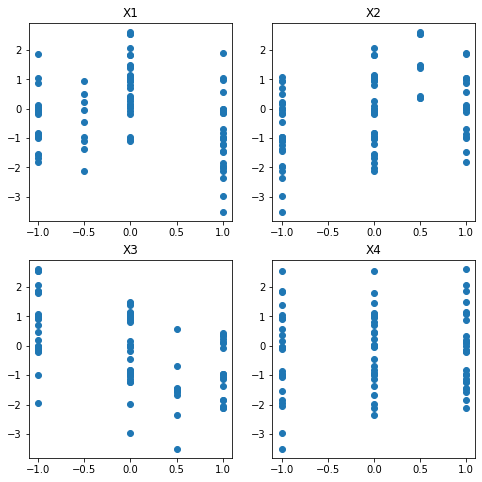

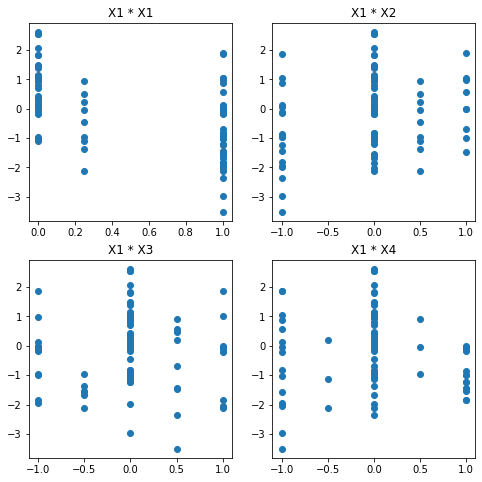

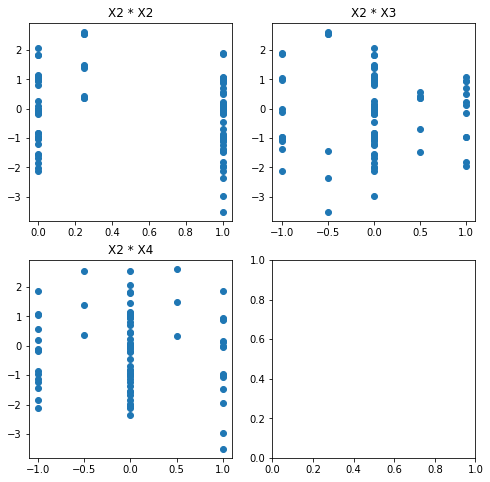

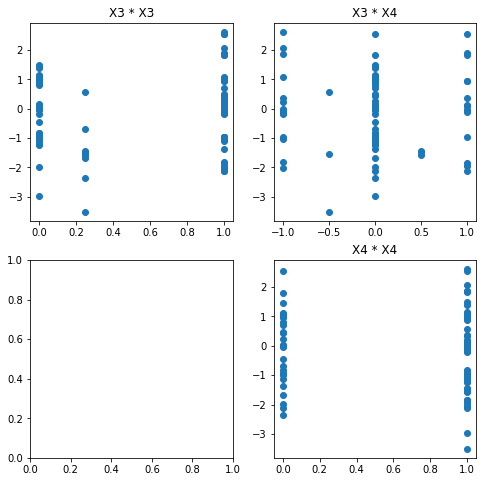

In [26]:

#-----------------------------------------------------
#регрессоры, которые будем включать в модель
reg = {
    0: X[:, 0], #x1
    1: X[:, 1], #x2
    2: X[:, 2], #x3
    3: X[:, 3], #x4
    
    4: X[:, 0] * X[:, 0], #x1x1
    5: X[:, 0] * X[:, 1], #x1x2
    6: X[:, 0] * X[:, 2], #x1x3
    7: X[:, 0] * X[:, 3], #x1x4
    
    8:  X[:, 1] * X[:, 1], #x2x2
    9:  X[:, 1] * X[:, 2], #x2x3
    10: X[:, 1] * X[:, 3], #x2x4    
    
    11: X[:, 2] * X[:, 2], #x3x3
    12: X[:, 2] * X[:, 3], #x3x4

    13: X[:, 3] * X[:, 3], #x4x4
}

model = np.ones((n))
model = np.column_stack((model, reg[0]))
model = np.column_stack((model, reg[1]))
model = np.column_stack((model, reg[11]))
model = np.column_stack((model, reg[12]))

#оценка через процедуру Кохрейна-Оркатта
print('\nОценка параметров лучшей модели процедурой Кохрейна-Оркатта:')
p=0
while 1:
    pk = OMNK(X=model, p=p)
    #pk = ((np.linalg.inv(model.T@model))@model.T)@(y)
    et = y - (pk.T@model.T).T
    p_prev = p
    p = ((np.linalg.inv(et[:n-1].T@et[:n-1]))@et[:n-1].T)@(et[1:n])
    print(p)
    if np.abs(p_prev - p) < 0.001:
        break
pk= OMNK(X=model, p=p)
print('p =', p)
print('pk = ')
print(pk.T)

model1 = np.ones((n))
model1 = np.column_stack((model1, reg[0]))
model1 = np.column_stack((model1, reg[1]))
model1 = np.column_stack((model1, reg[2]))
model1 = np.column_stack((model1, reg[3]))
model1 = np.column_stack((model1, reg[4]))
model1 = np.column_stack((model1, reg[5]))
model1 = np.column_stack((model1, reg[6]))
model1 = np.column_stack((model1, reg[7]))
model1 = np.column_stack((model1, reg[8]))
model1 = np.column_stack((model1, reg[9]))
model1 = np.column_stack((model1, reg[10]))
model1 = np.column_stack((model1, reg[11]))
model1 = np.column_stack((model1, reg[12]))
model1 = np.column_stack((model1, reg[13]))

#оценка ПОЛНОЙ МОДЕЛИ через процедуру Кохрейна-Оркатта
print('\nОценка параметров полной модели процедурой Кохрейна-Оркатта:')
p=0
while 1:
    pk1 = OMNK(X=model1, p=p)
    #pk = ((np.linalg.inv(model.T@model))@model.T)@(y)
    et = y - (pk1.T@model1.T).T
    p_prev = p
    p = ((np.linalg.inv(et[:n-1].T@et[:n-1]))@et[:n-1].T)@(et[1:n])
    print(p)
    if np.abs(p_prev - p) < 0.001:
        break
pk1 = OMNK(X=model1, p=p)
pk1 = ((np.linalg.inv(model1.T@model1))@model1.T)@(y)
print('p =', p)
print('pk1 = ')
print(pk1.T)

#гипотеза об адекватности модели по последним 6 наблюдениям
#tp = OMNK(X=model, y=y)
tp = pk
yp = model@tp
m = len(model[0])

e1 = y[n-6:] - yp[n-6:]
e2 = y[:n-6] - yp[:n-6]
d_f1 = (e1.T@e1) / (n - m)
d_f2 = (e2.T@e2) / (n - m)
#квантиль распределения Фишера
Fq = Fisher.ppf(1-0.05, n-m, 1e+10)
F = float(d_f1 / d_f2)
print('Гипотеза об адекватности модели по последним 6 наблюдениям:')
if F<Fq:
    print('F =', F, '=> модель адекватна')
else:
    print('F =', F, '=> модель не адекватна')

#графики остатков в различных координатах
e = y - yp

plt.scatter(range(n),e)
plt.title('Зависимость остатков от номера наблюдения')
plt.xlabel('i')
plt.ylabel('e')
plt.show()

plt.scatter(y, e)
plt.title('Зависимость остатков от y')
plt.xlabel('y')
plt.ylabel('e')
plt.show()

plt.scatter(model[:,1],e)
plt.title('Зависимость остатков от X1')
plt.xlabel('X1')
plt.ylabel('e')
plt.show()

plt.scatter(model[:,2],e)
plt.title('Зависимость остатков от X2')
plt.xlabel('X2')
plt.ylabel('e')
plt.show()

plt.scatter(model[:,3],e)
plt.title('Зависимость остатков от X3*X3')
plt.xlabel('X3*X3')
plt.ylabel('e')
plt.show()

plt.scatter(model[:,4],e)
plt.title('Зависимость остатков от X3*X4')
plt.xlabel('X3*X4')
plt.ylabel('e')
plt.show()

#-----------------------------------------------------
#оценка несмещенной дисперсии
def get_sigm(X=X, y=y):
    y_ = X@OMNK(X=X, y=y)
    e_ = y - y_
    sigm = (e_.T@e_) / (n - m)
    return sigm, e_

#-----------------------------------------------------
#доверительное оценивание для математического ожидания функции отклика
dx = 10
search = []
#факторы на интервале от -1 до 1
for x1 in np.linspace(-1, 1, dx):
    for x2 in np.linspace(-1, 1, dx):
        for x3 in np.linspace(-1, 1, dx):
            for x4 in np.linspace(-1, 1, dx):
                search.append(tp[0] + tp[1]*x1 + tp[2]*x2 + tp[3]*x3*x3 + tp[4]*x3*x4)
                if search[len(search)-1] > 5.54:
                    print(x1, x2, x3, x4, ' = ', search[len(search)-1])

sigm, _ = get_sigm(X=model, y=y)

#максимальное мат ожидание
etta_ = np.max(search)

def ett(tp):
    etta = np.zeros((len(tp)))
    x1, x2, x3, x4 = -1, 1, 1, 1
    etta[0] = 1
    etta[1] = tp[1]*x1
    etta[2] = tp[2]*x2
    etta[3] = tp[3]*x3*x3
    etta[4] = tp[4]*x3*x4    
    return np.array(etta)

f = ett(np.ones(len(tp)))
sigm_tetta_ = sigm * np.sqrt((f.T@np.linalg.inv(model.T@model))@f)
sigm_tetta_ = float(sigm_tetta_)

interval_M = []
#квантиль распределения Стьюдента
Fs = Student.ppf(1 - 0.05/2, n-m) 
interval_M.append(etta_ - Fs * sigm_tetta_)
interval_M.append(etta_ + Fs * sigm_tetta_)
interval_M = np.array(interval_M)
print('Доверительный интервал для максимального математического ожидания отклика:')
print('[' + str(interval_M[0]) + ';' + str(interval_M[1]) + ']')
print('y_max =', np.max(search))

#анализ корреляционных полей
fig, sub = plt.subplots(2, 2,figsize=(8,8))
for i, ax in enumerate(sub.flatten()):
    ax.scatter(X[:,i], y)
    ax.set_title('X' + str(i+1))
    if i == 3:
        break

fig, sub = plt.subplots(2, 2,figsize=(8,8))
for i, ax in enumerate(sub.flatten()):
    ax.scatter(X[:,0]*X[:,i], y)
    ax.set_title('X1 * X' + str(i+1))
    if i == 3:
        break

fig, sub = plt.subplots(2, 2,figsize=(8,8))
for i, ax in enumerate(sub.flatten(), start=1):
    ax.scatter(X[:,1]*X[:,i], y)
    ax.set_title('X2 * X' + str(i+1))
    if i == 3:
        break

fig, sub = plt.subplots(2, 2, figsize=(8,8))
for i, ax in enumerate(sub.flatten(), start=2):
    ax.scatter(X[:,2]*X[:,i], y)
    ax.set_title('X3 * X' + str(i+1))
    if i == 3:
        break

plt.scatter(X[:,3]*X[:,3], y)
plt.title('X4 * X4')
